# CTD Module

This module is the only module to ingest the CTD data files from the cruise. It is currently setup for a CTD downcast file and a CTD Log file but is easily adaptable for a single CTD data file. This module creates rdata structures for use with the other scripts in this suite.


| Cast | ... | Lat | Lon |
|------|-----|-----|-----|
| 1    | ... |Lat1 | Lon1|


In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: ‘R.matlab’

The following objects are masked from ‘package:base’:

    getOption, isOpen

Loading required package: openxlsx
Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Loading required package: geosphere
Loading required package: readxl
Loading required package: data.table
Loading required package: rworldmap
Loading required package: sp
Error: package or namespace load failed for ‘rworldmap’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called ‘fields’
Loading required package: rworldxtra


In [2]:
## Downcast file
ctd = read.xlsx('Raw Data/CTD/DataZoo - P1706 CTD Downcast Data.xlsx')
ctd$Time = conv_excel_time(ctd$DateTime, tz = 'UTC')

## CTD Log file
ctd.log = read.xlsx('Raw Data/CTD/DataZoo - P1706 CTD Cast Log.xlsx', sheet='Data')
ctd.log$time = conv_excel_time(ctd.log$DateTime, tz = 'GMT')

## Check file structures and variaible types
str(ctd)
str(ctd.log)

'data.frame':	41780 obs. of  35 variables:
 $ Cruise          : chr  "CCE-P1706" "CCE-P1706" "CCE-P1706" "CCE-P1706" ...
 $ Cycle           : chr  "Cycle0" "Cycle0" "Cycle0" "Cycle0" ...
 $ EventNo         : num  3 3 3 3 3 3 3 3 3 3 ...
 $ Cast            : num  1 1 1 1 1 1 1 1 1 1 ...
 $ DateTime        : num  42888 42888 42888 42888 42888 ...
 $ Direction       : chr  "down" "down" "down" "down" ...
 $ Pressure        : num  2 3 4 5 6 7 8 9 10 11 ...
 $ Depth           : num  1.99 2.98 3.97 4.96 5.96 ...
 $ T090C           : num  16.9 16.8 16.9 16.9 16.8 ...
 $ T190C           : num  16.8 16.8 16.9 16.9 16.8 ...
 $ Cond1           : num  4.3 4.29 4.3 4.3 4.29 ...
 $ Cond2           : num  4.29 4.29 4.3 4.3 4.3 ...
 $ Sal00           : num  33.4 33.4 33.4 33.4 33.4 ...
 $ Sal11           : num  33.4 33.4 33.4 33.4 33.4 ...
 $ O2              : num  195 196 195 195 195 ...
 $ O2.Sat          : num  81 81.1 81 80.9 80.8 ...
 $ PAR.surface     : num  8632 8632 8632 8632 8632 ...
 $ PAR  

In [3]:
## A function to take the log file position and add it to the downcast data.
add.ctd.log.position = function(ctd, ctd.log) {
    ctd$Lat = NA
    ctd$Lon = NA
    ctd$Type = NA
    
    rej = c()
    for (i in 1:nrow(ctd)) {
        l = which(ctd.log$EventNo == ctd$EventNo[i])

        if (length(l) == 1) {
            ctd$Lat[i] = ctd.log$Lat[l]
            ctd$Lon[i] = ctd.log$Lon[l]
            ctd$Type = ctd.log$Station.Type[l]
        } else {
            rej = c(rej, i)
        }
    }
    print(paste0('Number of unmatched bins: ', length(rej)))
    ctd
}

ctd = add.ctd.log.position(ctd, ctd.log)

[1] "Number of unmatched bins: 3440"


In [ ]:
save(ctd, file = 'RStates/CTD.all.rdata')

---

# Par and Transmission analysis

In [ ]:
pt.comparison.plot = function(cast){
    l = which(ctd$Cast == cast)
    
    if (max(ctd$PAR[l], na.rm = TRUE) < 100) {
        return()
    }
    PAR = ctd$PAR[l] / ctd$PAR[l[1]]
    TRANS = cumprod(ctd$Trans[l]/100)
    Depth = ctd$Pressure[l]
    
    plot(PAR, Depth, ylim=c(200, 0), yaxs='i', main=paste('Cast -', cast), pch=16, cex=0.6)
    points(TRANS, Depth, col='blue', pch=16, cex=0.3)
    
    plot(PAR, TRANS^2)
    lm.log = lm(TRANS^2 ~ PAR)
    lines(PAR, predict(lm.log)[1:length(PAR)])
}

unique(ctd$Cast)

In [ ]:
pdf('Output/CTD - Transmission and PAR analysis.pdf')
par(mfrow=c(2,2))

for (i in unique(ctd$Cast)) {
    pt.comparison.plot(i)
}

dev.off()

In [ ]:
tchl.comparison.plot = function(cast){
    l = which(ctd$Cast == cast & ctd$Pressure < 100)
    
    if (max(ctd$Fluor[l], na.rm = TRUE) < 1) {
        return()
    }
    
    CHL = ctd$Fluor[l] / max(ctd$Fluor[l], na.rm = TRUE)
    TRANS = ctd$Trans[l]/100
    Depth = ctd$Pressure[l]
    
    plot(CHL, Depth, ylim=c(200, 0), yaxs='i', main=paste('Cast -', cast), pch=16, cex=0.6, xlim=c(0,2))
    points(TRANS, Depth, col='blue', pch=16, cex=0.3)
    
    plot(CHL, TRANS, col=make.div.pal(ctd$Pressure[l], n = 100), pch=16, ylim=c(0.8,1), xlim=c(0,1))
    lm.log = lm(TRANS ~ CHL)
    points(CHL, predict(lm.log)[1:length(CHL)], pch=16, cex=0.5, col='red')
}

unique(ctd$Cast)

In [ ]:
pdf('Output/CTD - Transmission and CHL analysis.pdf')

par(mfrow=c(2,2))

for (i in unique(ctd$Cast)) {
    try(tchl.comparison.plot(i))
}

dev.off()

# Plot Profiles

This section will provide the utility to plot various profiles for visual verification.

In [ ]:
par(mfrow=c(3,3))
for (i in unique(ctd$Cast)) {
    l = which(ctd$Cast == i)
    plot(ctd$Trans[l], ctd$Depth[l], ylim=c(100,0), yaxs='i', xlab='Transmission', xlim=c(80,100), main=i, pch=16, cex=0.4)
}

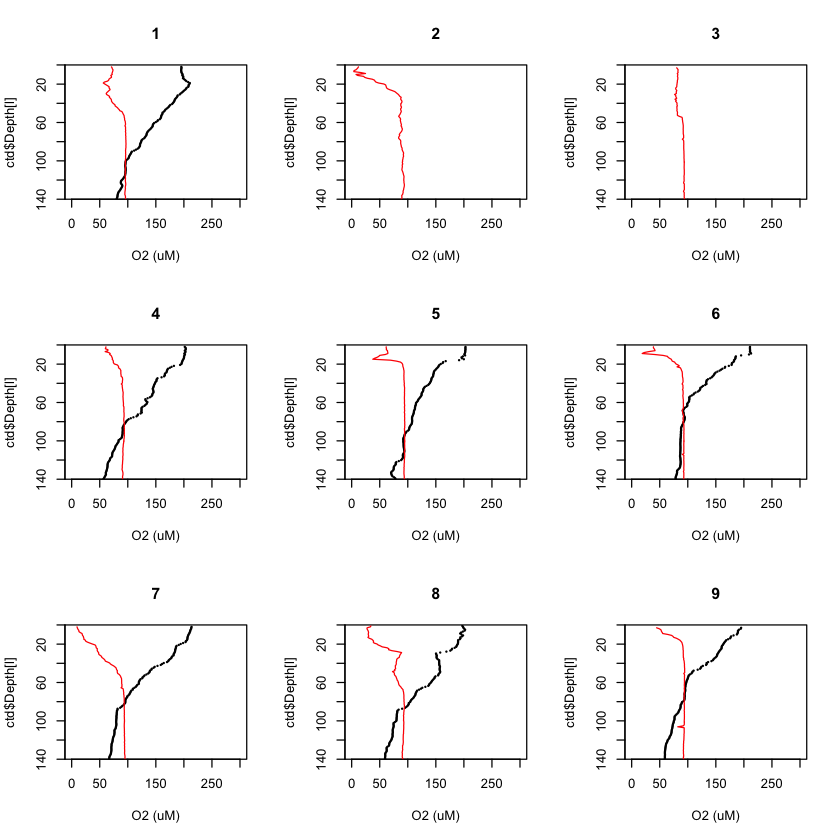

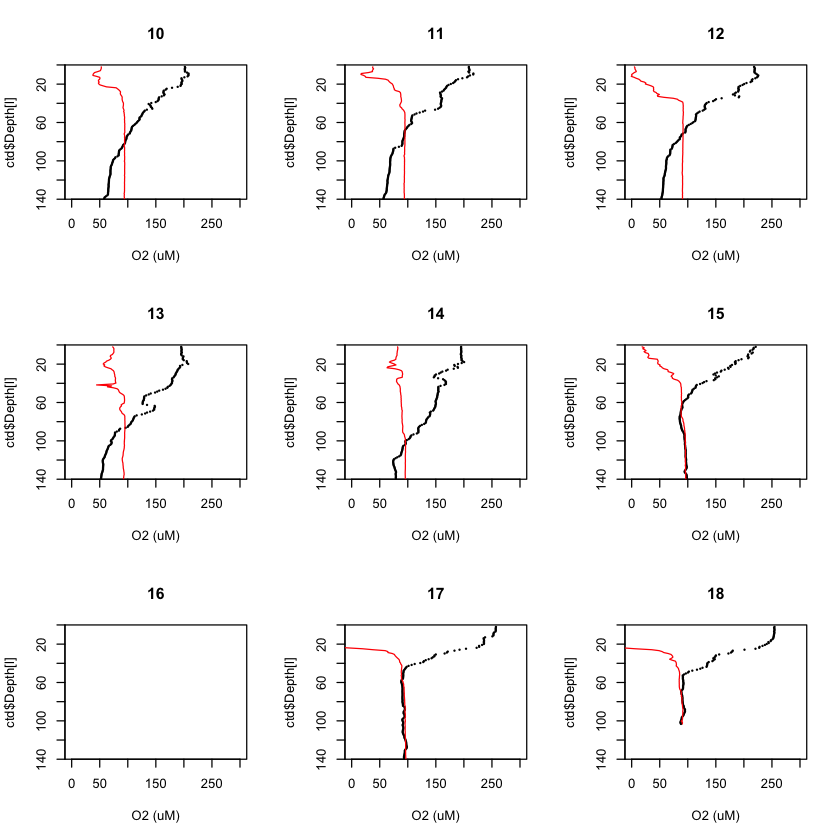

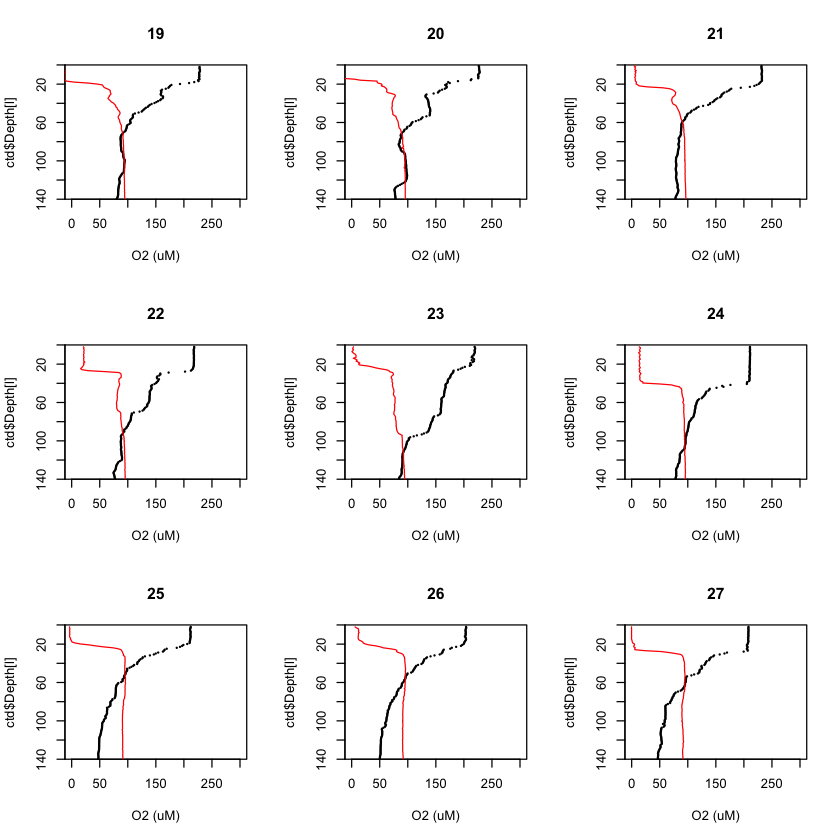

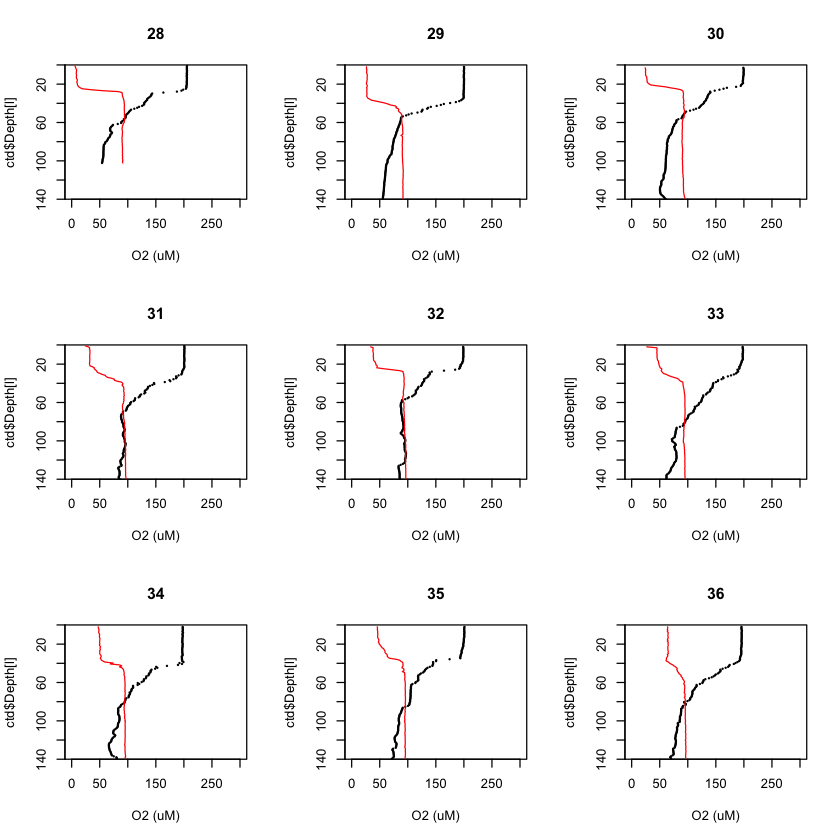

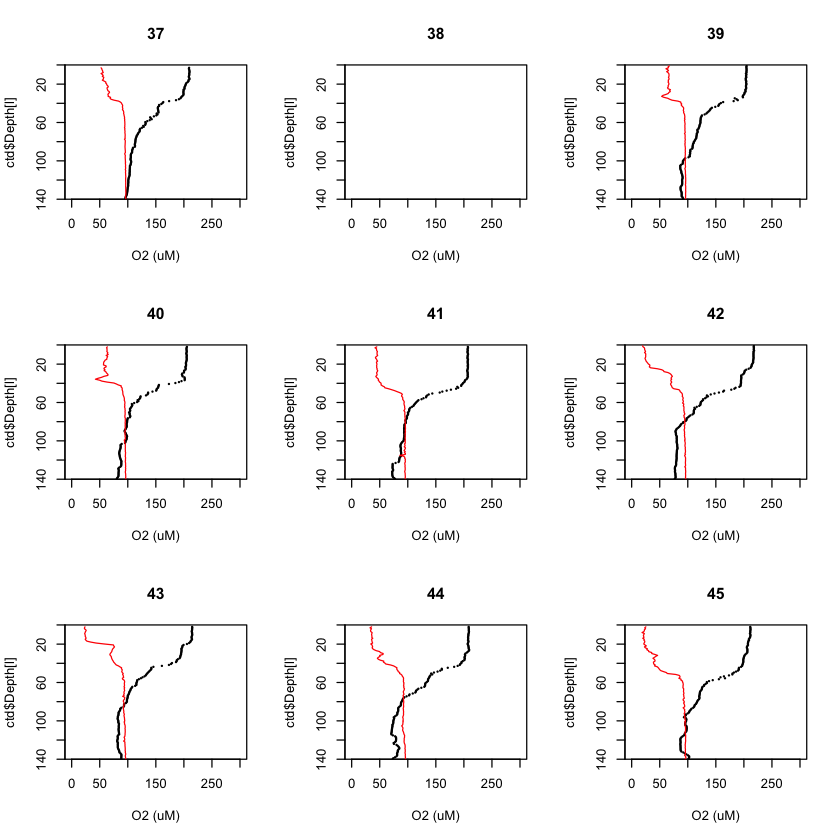

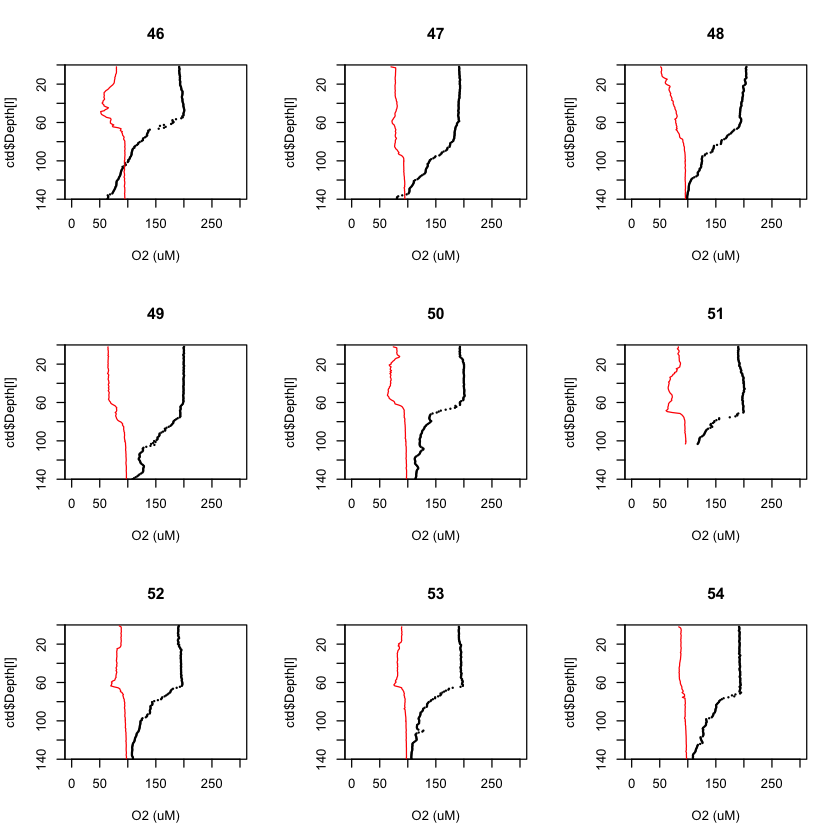

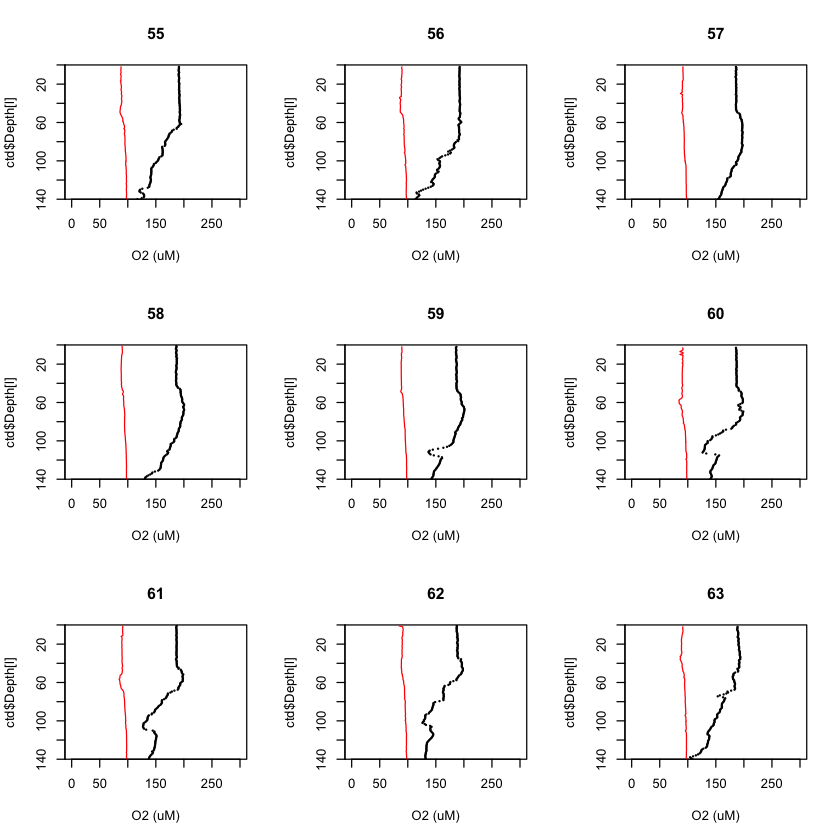

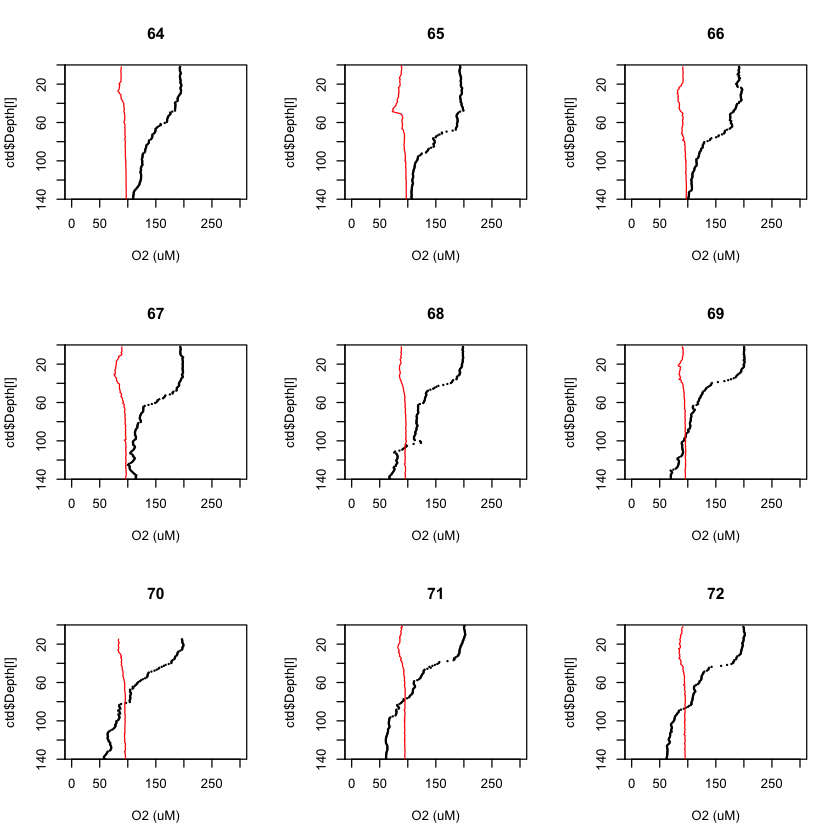

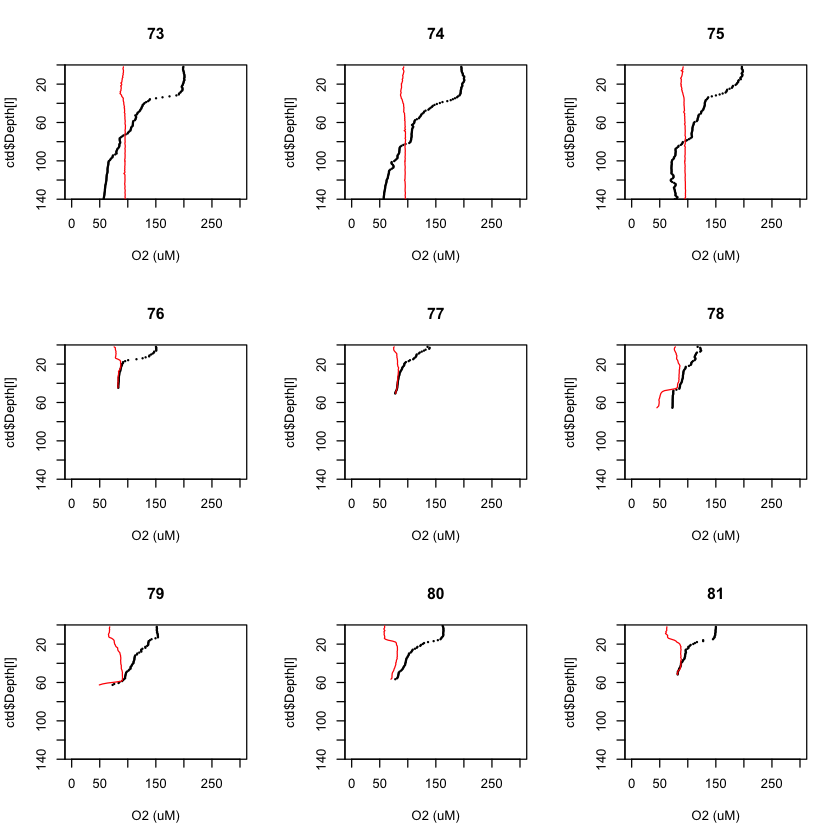

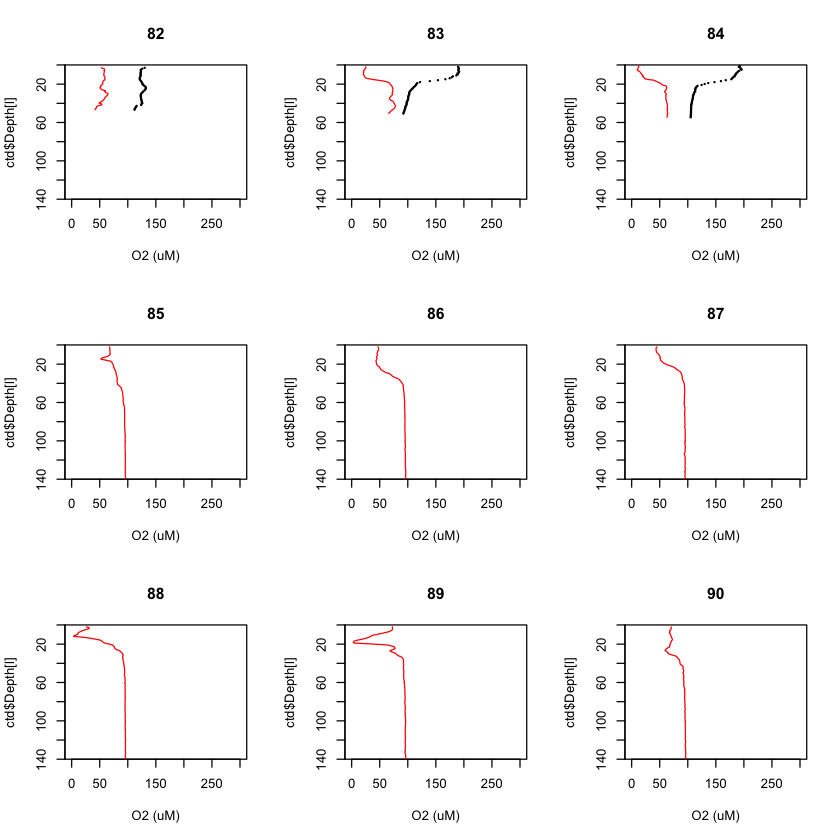

In [23]:
par(mfrow=c(3,3))
for (i in unique(ctd$Cast)) {
    l = which(ctd$Cast == i & !is.na(ctd$T090C))
    plot(ctd$O2[l], ctd$Depth[l], ylim=c(140,0), yaxs='i', xlab='O2 (uM)', main=i, pch=16, cex=0.4, xlim=c(0,300))
    #lines(ctd$T090C[l]*10, ctd$Depth[l], pch=20, col='red')
    lines(100 + (ctd$Trans[l]-100)*5, ctd$Depth[l], pch=20, col='red')
}